In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Dataset Parameters
path = "/kaggle/input/satellite-image-classification/data"
batch_size = 32
height, width = 128, 128
epochs = 20
seed = 1234

In [17]:
# Documentation of Models and Preprocessing Techniques
models_applied = []
data_preprocessing = "Rescaling pixel values (0-255) to the range 0-1"
loss_function = "Sparse Categorical Crossentropy"
optimizer = "Adam"
evaluation_parameters = ["Accuracy"]

In [18]:
# Load Dataset
train = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(height, width),
    batch_size=batch_size
)
val = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(height, width),
    batch_size=batch_size
)
class_names = train.class_names
num_classes = len(class_names)

Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.


In [19]:
# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomBrightness(0.2)
])

# Preprocessing Layer
preprocessing_layer = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1.0 / 255),
    tf.keras.layers.Normalization(mean=0.5, variance=0.25)
])

In [20]:
# Visualize Training and Validation Samples
def visualize_samples(dataset, title):
    plt.figure(figsize=(15, 7))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"{title}: {class_names[labels[i]]}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

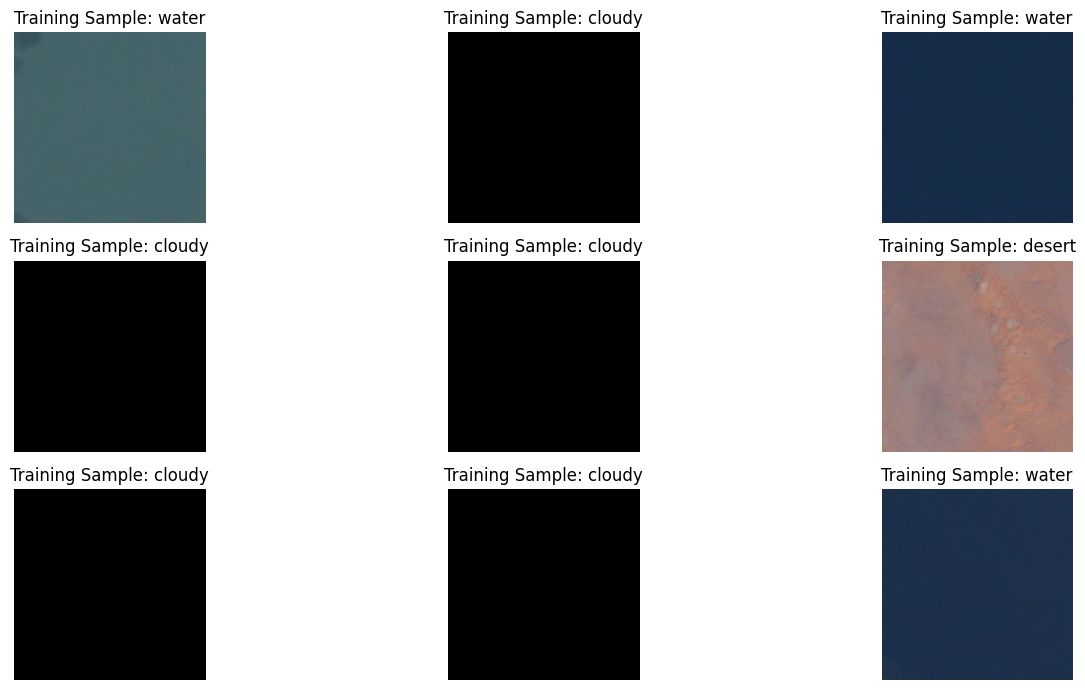

In [21]:
visualize_samples(train, "Training Sample")

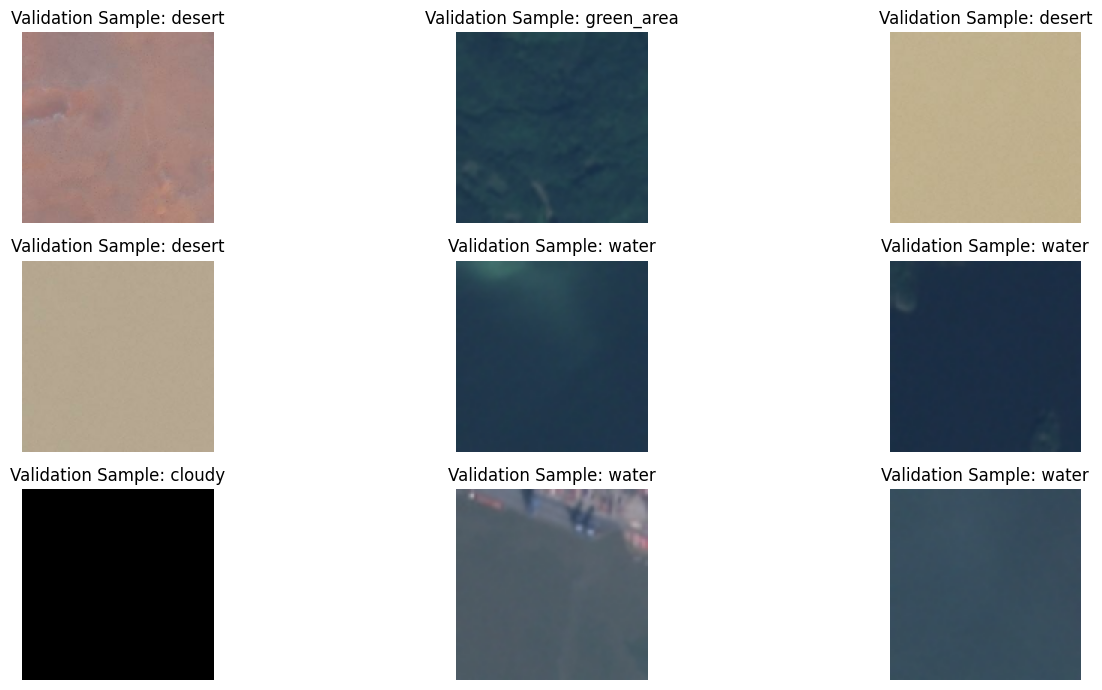

In [22]:
visualize_samples(val, "Validation Sample")

In [23]:
# Custom CNN Model Definition
def build_custom_cnn(num_classes):
    models_applied.append("Custom CNN")
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(height, width, 3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

# Transfer Learning Models
def create_transfer_model(base_model_name, base_model, num_classes):
    models_applied.append(base_model_name)
    base_model.trainable = False  # Freeze base model layers
    return tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

transfer_models = {
    "MobileNetV2": tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(height, width, 3)),
    "ResNet50": tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=(height, width, 3)),
    "InceptionV3": tf.keras.applications.InceptionV3(weights="imagenet", include_top=False, input_shape=(height, width, 3)),
    "EfficientNetB0": tf.keras.applications.EfficientNetB0(weights="imagenet", include_top=False, input_shape=(height, width, 3)),
    "DenseNet121": tf.keras.applications.DenseNet121(weights="imagenet", include_top=False, input_shape=(height, width, 3)),
    "Xception": tf.keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(height, width, 3))
}

In [24]:
results = {}

In [25]:
def evaluate_model(model_name, model):
    print(f"\nTraining and Evaluating: {model_name}")
    
    # Compile Model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train Model
    history = model.fit(
        train,
        validation_data=val,
        epochs=epochs,
        verbose=1
    )
    
    # Evaluate Model
    val_labels = []
    val_predictions = []
    for images, labels in val:
        predictions = model.predict(images)
        val_labels.extend(labels.numpy())
        val_predictions.extend(np.argmax(predictions, axis=1))
    
    # Metrics
    report = classification_report(val_labels, val_predictions, target_names=class_names, output_dict=True)
    conf_matrix = confusion_matrix(val_labels, val_predictions)
    
    # Use predicted probabilities for ROC curve, not argmax
    predictions_prob = model.predict(val)  # This gives the probabilities
    fpr, tpr, _ = roc_curve(val_labels, predictions_prob[:, 1], pos_label=1)  # For binary, or adjust for multiclass
    roc_auc = auc(fpr, tpr)
    
    # Store Results
    results[model_name] = {
        "model": model,
        "history": history.history,
        "classification_report": report,
        "confusion_matrix": conf_matrix
    }
    
    # Visualization
    def plot_metrics(history, model_name):
        epochs_range = range(len(history['accuracy']))
        accuracy = history['accuracy']
        val_accuracy = history['val_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']
        
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, accuracy, label='Training Accuracy')
        plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title(f'{model_name} - Accuracy')
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title(f'{model_name} - Loss')
        plt.show()
        
    plot_metrics(history.history, model_name)
    
    # Confusion Matrix Heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return val_predictions, val_labels



Training and Evaluating: Custom CNN
Epoch 1/20


I0000 00:00:1734593403.919378     102 service.cc:145] XLA service 0x79b8c0004fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734593403.919435     102 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 10/141 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4647 - loss: 1.2503

I0000 00:00:1734593406.485693     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7064 - loss: 0.5961

I0000 00:00:1734593417.390341     101 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion', 8 bytes spill stores, 8 bytes spill loads



141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.7069 - loss: 0.5948 - val_accuracy: 0.8819 - val_loss: 0.2502
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9027 - loss: 0.2262 - val_accuracy: 0.9272 - val_loss: 0.2087
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8976 - loss: 0.2221 - val_accuracy: 0.8925 - val_loss: 0.2342
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9181 - loss: 0.1917 - val_accuracy: 0.9378 - val_loss: 0.1901
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9264 - loss: 0.1678 - val_accuracy: 0.9298 - val_loss: 0.1598
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9370 - loss: 0.1396 - val_accuracy: 0.9174 - val_loss: 0.1865
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9142 - loss: 0.1868 - val_accuracy: 0.9218 - val_loss: 0.1938
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9410 - loss: 0.1463 - val_accuracy: 0.93

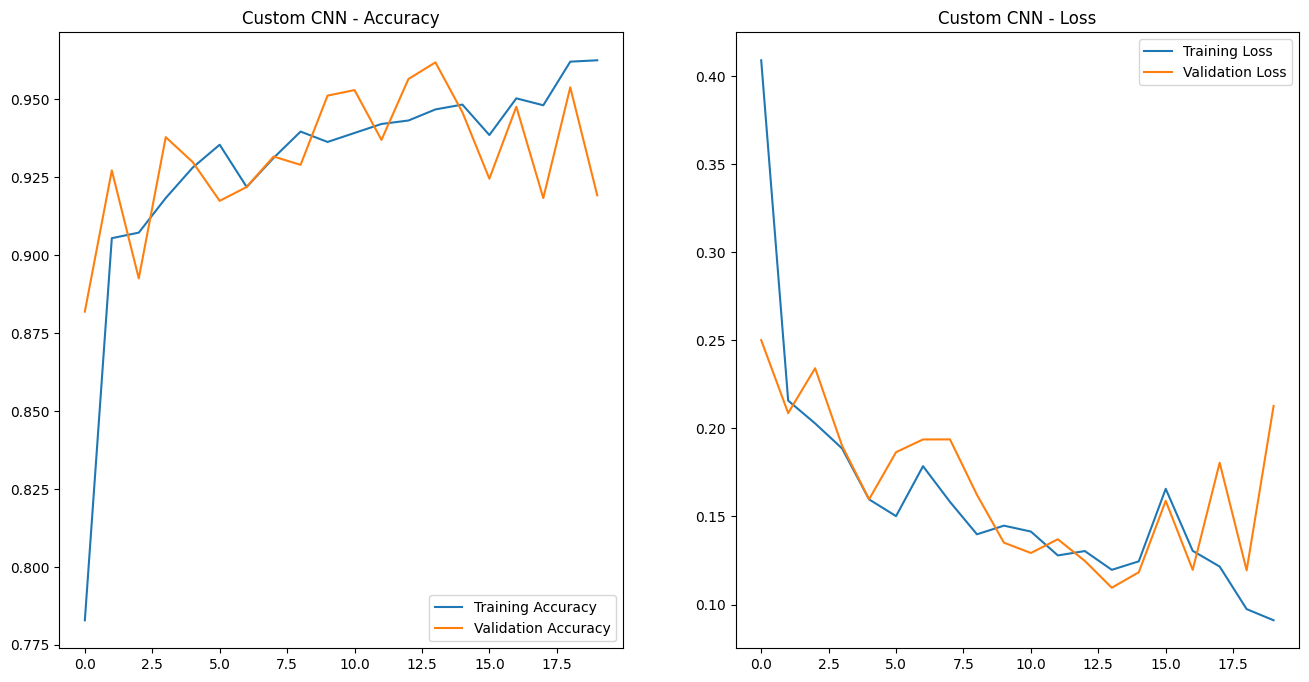

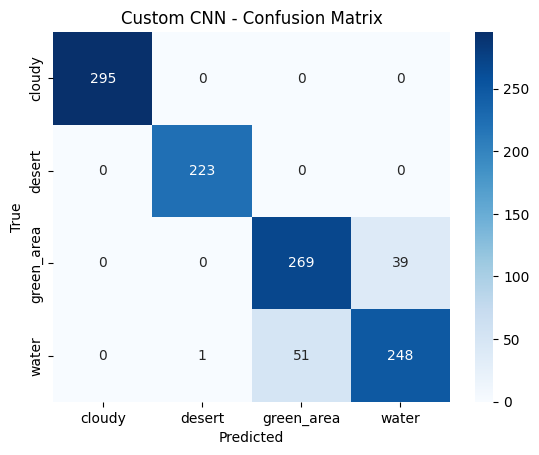

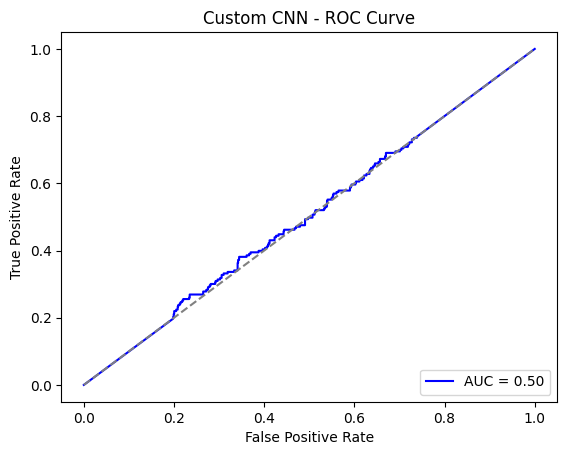

([3,
  2,
  0,
  1,
  2,
  0,
  3,
  2,
  1,
  3,
  0,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  1,
  0,
  2,
  0,
  3,
  0,
  0,
  3,
  2,
  2,
  1,
  3,
  0,
  2,
  3,
  3,
  2,
  3,
  2,
  0,
  1,
  2,
  2,
  3,
  0,
  2,
  2,
  1,
  2,
  2,
  3,
  1,
  1,
  1,
  3,
  0,
  0,
  2,
  0,
  3,
  0,
  2,
  3,
  0,
  3,
  0,
  0,
  0,
  3,
  1,
  3,
  0,
  0,
  2,
  0,
  1,
  1,
  2,
  2,
  1,
  1,
  3,
  2,
  1,
  3,
  2,
  3,
  2,
  0,
  3,
  2,
  2,
  3,
  2,
  1,
  3,
  0,
  1,
  2,
  0,
  0,
  1,
  0,
  3,
  1,
  1,
  2,
  2,
  3,
  3,
  2,
  3,
  1,
  2,
  3,
  3,
  3,
  3,
  2,
  0,
  2,
  0,
  2,
  1,
  3,
  1,
  2,
  2,
  2,
  2,
  3,
  1,
  0,
  2,
  3,
  1,
  2,
  3,
  2,
  0,
  1,
  3,
  3,
  2,
  0,
  3,
  0,
  2,
  0,
  2,
  2,
  0,
  1,
  3,
  3,
  2,
  2,
  0,
  2,
  2,
  0,
  1,
  0,
  2,
  2,
  3,
  3,
  0,
  2,
  2,
  2,
  2,
  0,
  3,
  0,
  2,
  1,
  3,
  1,
  2,
  2,
  3,
  3,
  0,
  0,
  2,
  0,
  0,
  0,
  1,
  0,
  3,
  0,
  1,
  3,
  2,
  2,
  1,
  0,
  3,
  0,
  3,


In [26]:
# Train Custom CNN
cnn_model = build_custom_cnn(num_classes)
evaluate_model("Custom CNN", cnn_model)


Training and Evaluating: MobileNetV2
Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.8673 - loss: 0.3489 - val_accuracy: 0.9929 - val_loss: 0.0312
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9913 - loss: 0.0353 - val_accuracy: 0.9938 - val_loss: 0.0217
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9924 - loss: 0.0261 - val_accuracy: 0.9947 - val_loss: 0.0166
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9889 - loss: 0.0281 - val_accuracy: 0.9947 - val_loss: 0.0177
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9950 - loss: 0.0214 - val_accuracy: 0.9787 - val_loss: 0.0576
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9948 - loss: 0.0213 - val_accuracy: 0.9929 - val_loss: 0.0194
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9931 - loss: 0.0200 - val_accuracy: 0.9956 - val_loss: 0.0139
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc

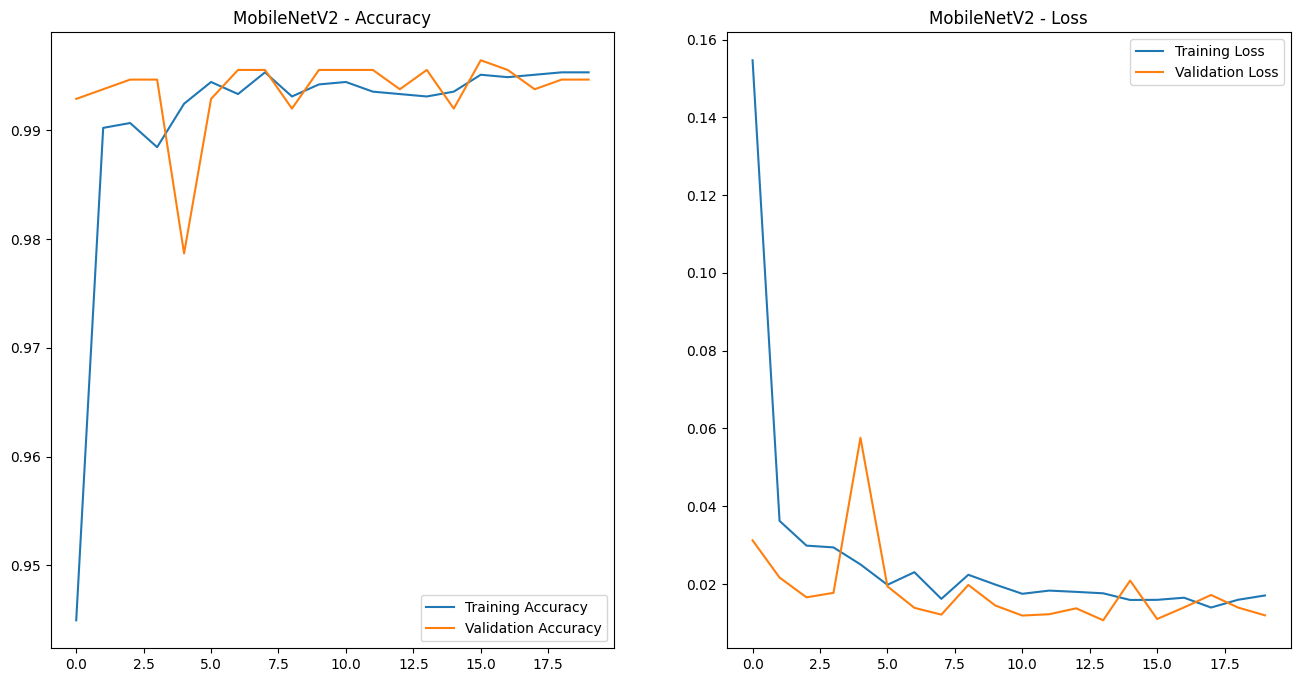

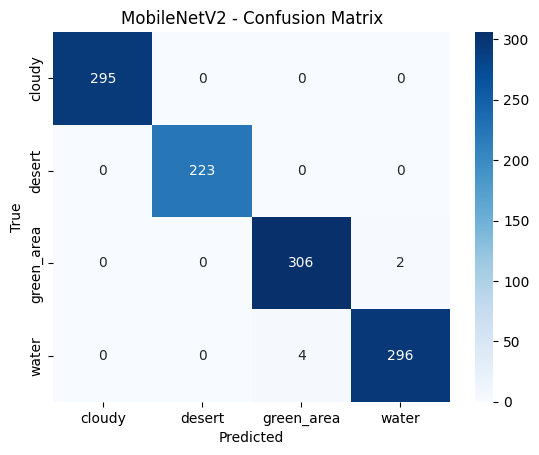

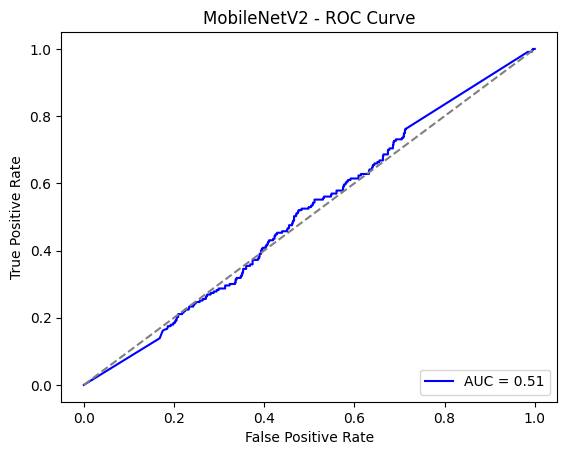


Training and Evaluating: ResNet50
Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.8866 - loss: 0.2995 - val_accuracy: 0.9938 - val_loss: 0.0153
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9983 - loss: 0.0098 - val_accuracy: 0.9902 - val_loss: 0.0304
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9967 - loss: 0.0082 - val_accuracy: 0.9938 - val_loss: 0.0147
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9967 - loss: 0.0110 - val_accuracy: 0.9938 - val_loss: 0.0119
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 0.9956 - val_loss: 0.0095
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9947 - val_loss: 0.0127
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9984 - loss: 0.0048 - val_accuracy: 0.9929 - val_loss: 0.0139
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accura

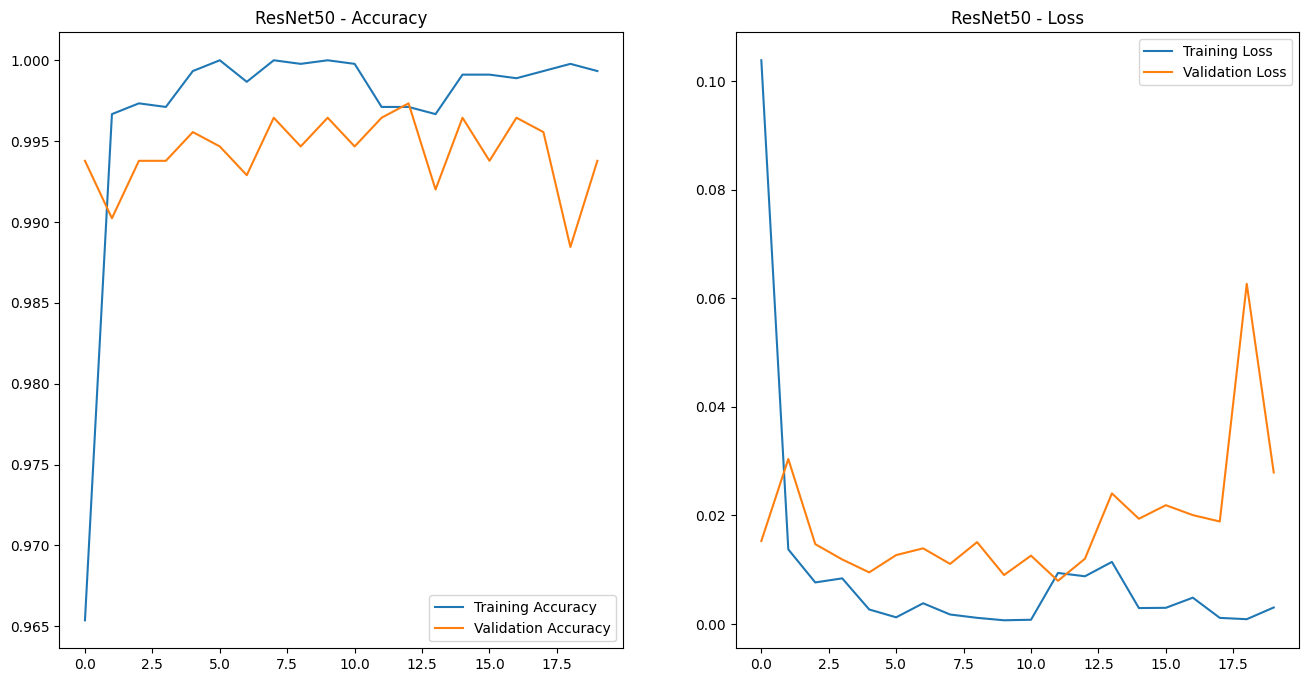

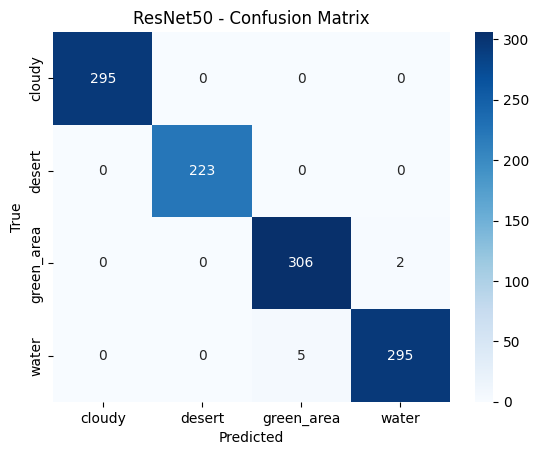

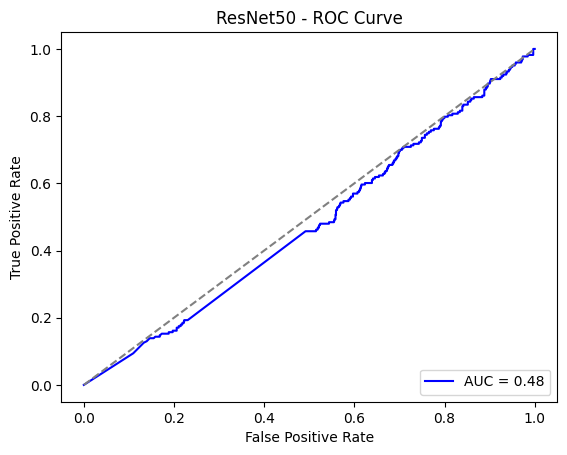


Training and Evaluating: InceptionV3
Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - accuracy: 0.7786 - loss: 7.1025 - val_accuracy: 0.9520 - val_loss: 0.1299
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8926 - loss: 0.3081 - val_accuracy: 0.9538 - val_loss: 0.1234
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8830 - loss: 0.3102 - val_accuracy: 0.9520 - val_loss: 0.1388
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8865 - loss: 0.3159 - val_accuracy: 0.9769 - val_loss: 0.0834
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8832 - loss: 0.2891 - val_accuracy: 0.9742 - val_loss: 0.1138
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8534 - loss: 0.3477 - val_accuracy: 0.9574 - val_loss: 0.2079
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7971 - loss: 0.4188 - val_accuracy: 0.9609 - val_loss: 0.1199
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - ac

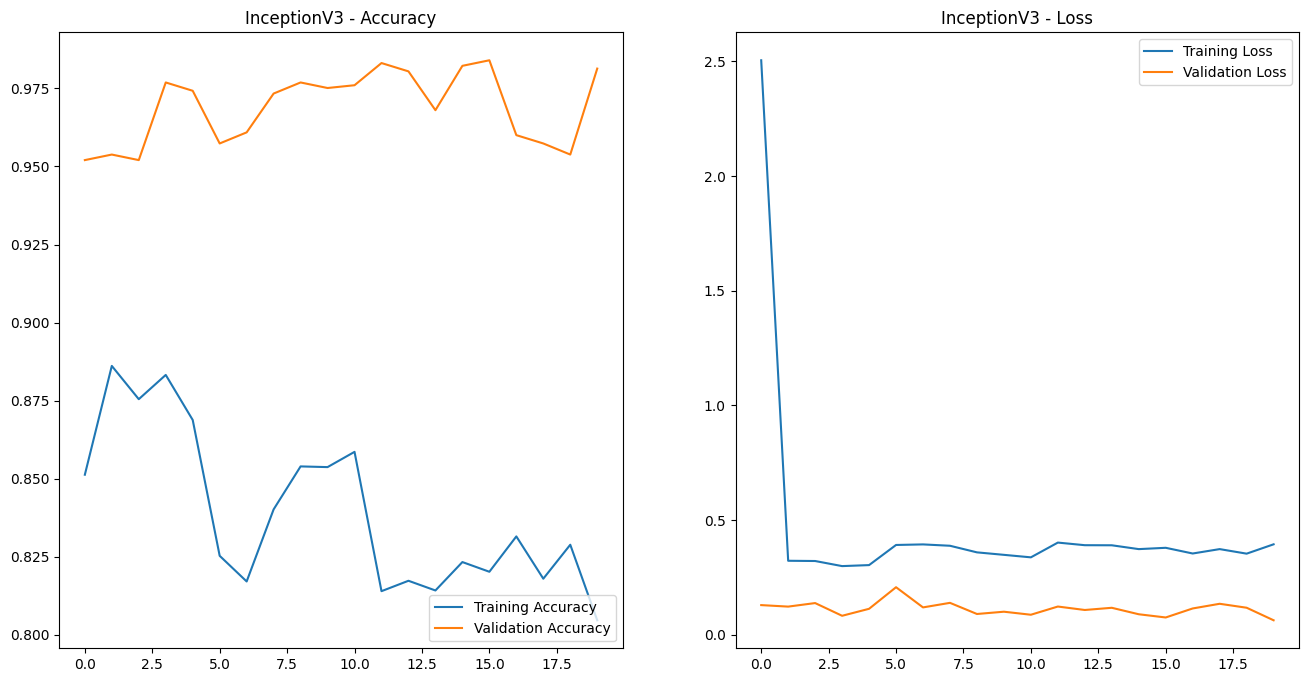

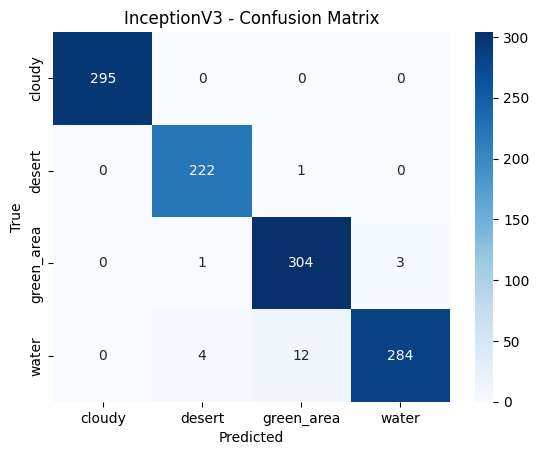

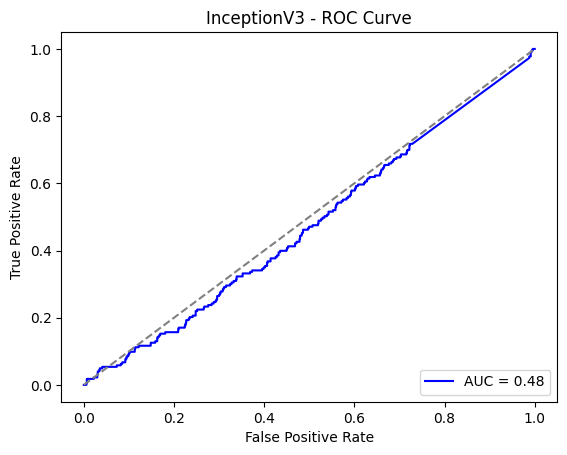


Training and Evaluating: EfficientNetB0
Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 51s 185ms/step - accuracy: 0.8270 - loss: 0.4692 - val_accuracy: 0.9529 - val_loss: 0.1228
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9499 - loss: 0.1438 - val_accuracy: 0.9760 - val_loss: 0.0549
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9641 - loss: 0.1040 - val_accuracy: 0.9858 - val_loss: 0.0465
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9795 - loss: 0.0653 - val_accuracy: 0.9778 - val_loss: 0.0635
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9755 - loss: 0.0695 - val_accuracy: 0.9920 - val_loss: 0.0263
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9790 - loss: 0.0606 - val_accuracy: 0.9911 - val_loss: 0.0279
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9838 - loss: 0.0497 - val_accuracy: 0.9920 - val_loss: 0.0257
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step -

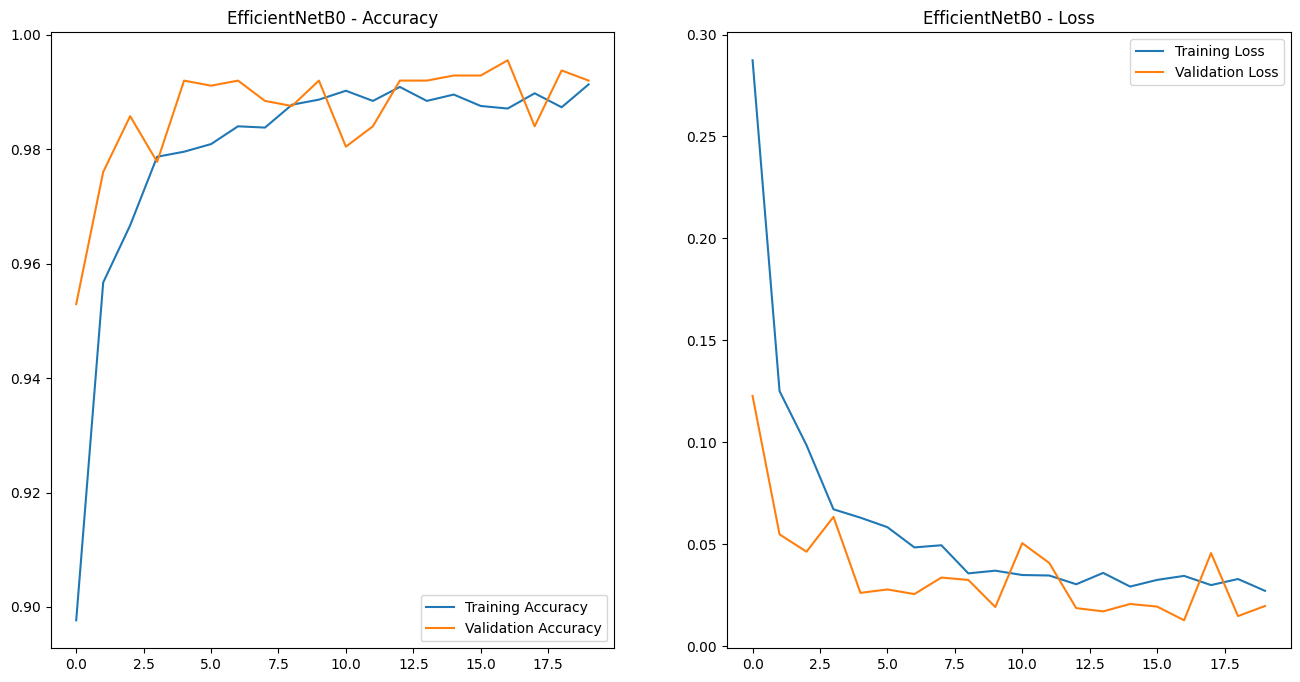

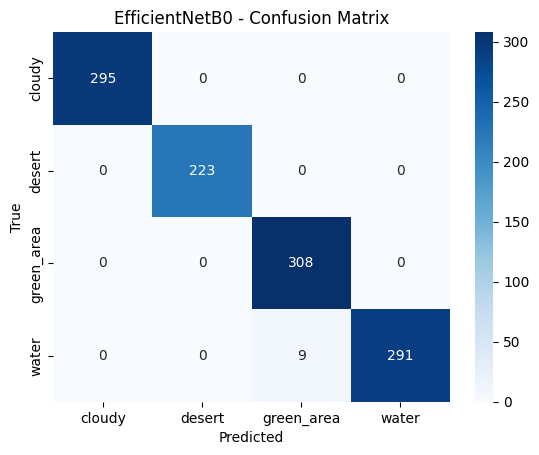

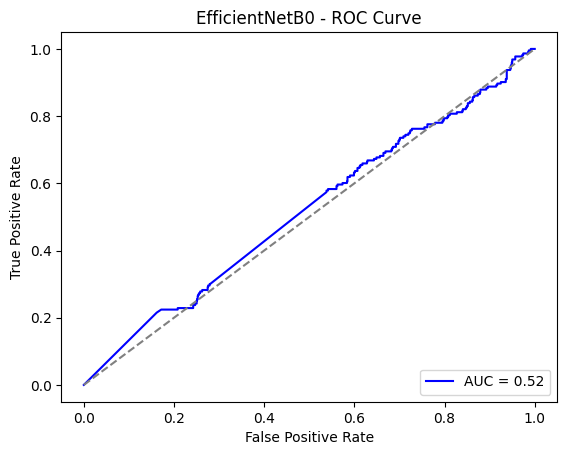


Training and Evaluating: DenseNet121
Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 48s 192ms/step - accuracy: 0.8886 - loss: 0.5517 - val_accuracy: 0.9920 - val_loss: 0.0258
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9883 - loss: 0.0395 - val_accuracy: 0.9902 - val_loss: 0.0204
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9889 - loss: 0.0327 - val_accuracy: 0.9964 - val_loss: 0.0151
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9931 - loss: 0.0314 - val_accuracy: 0.9929 - val_loss: 0.0166
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9918 - loss: 0.0274 - val_accuracy: 0.9973 - val_loss: 0.0095
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9951 - loss: 0.0161 - val_accuracy: 0.9902 - val_loss: 0.0281
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9905 - loss: 0.0272 - val_accuracy: 0.9973 - val_loss: 0.0095
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - ac

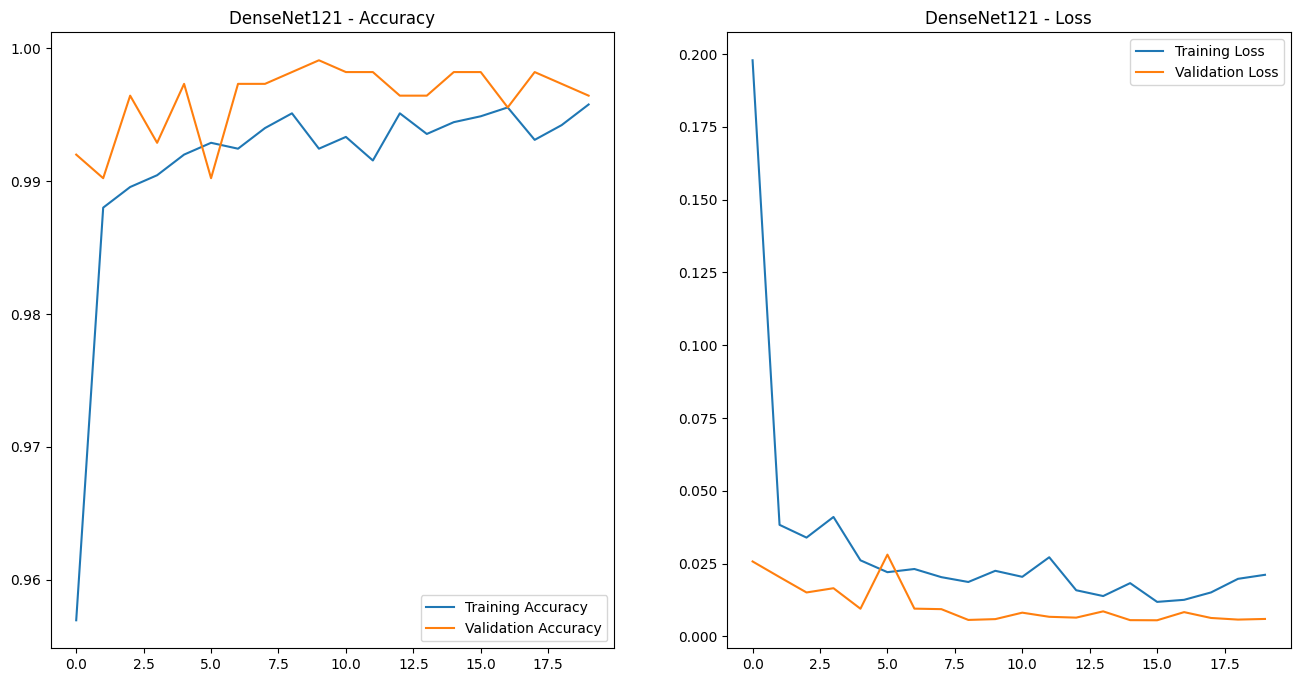

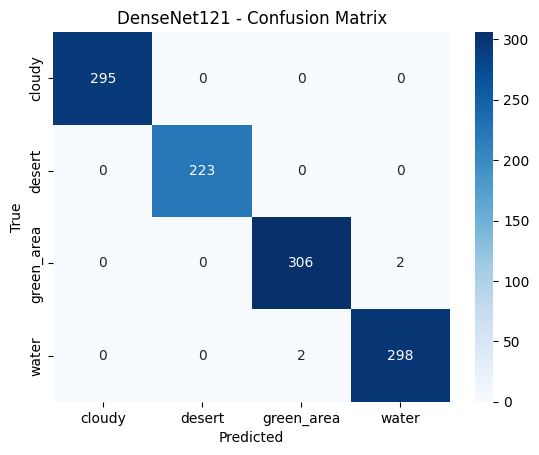

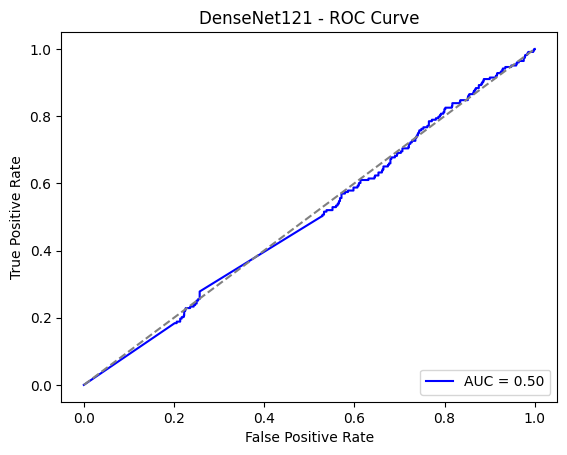


Training and Evaluating: Xception
Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.7314 - loss: 6.6505 - val_accuracy: 0.9361 - val_loss: 0.1786
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9042 - loss: 0.2613 - val_accuracy: 0.9698 - val_loss: 0.1366
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9086 - loss: 0.2536 - val_accuracy: 0.9849 - val_loss: 0.0549
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9112 - loss: 0.2042 - val_accuracy: 0.9787 - val_loss: 0.0583
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9370 - loss: 0.1621 - val_accuracy: 0.9751 - val_loss: 0.0680
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9098 - loss: 0.2000 - val_accuracy: 0.9813 - val_loss: 0.0535
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9354 - loss: 0.1610 - val_accuracy: 0.9760 - val_loss: 0.0793
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accura

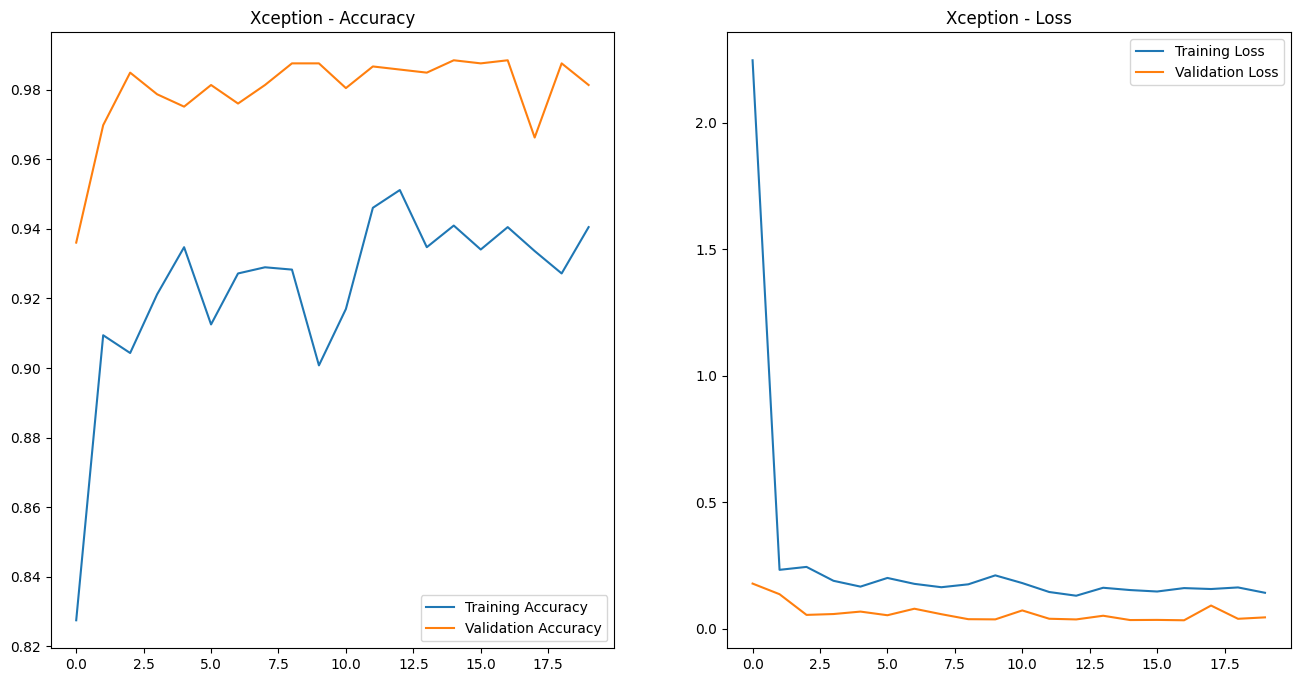

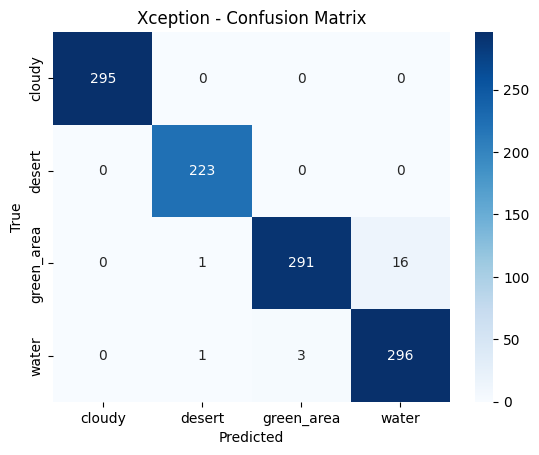

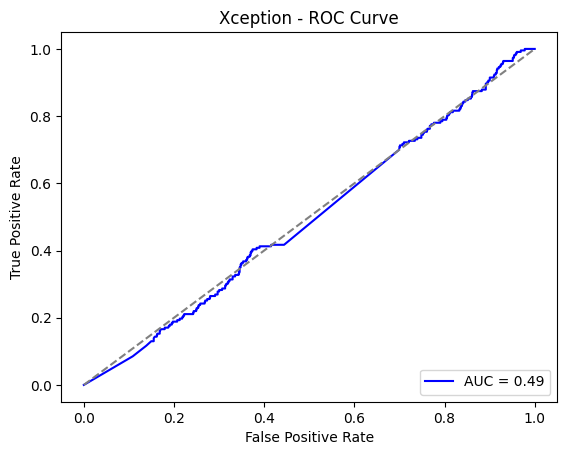

In [27]:

# Train Transfer Learning Models
for name, base_model in transfer_models.items():
    model = create_transfer_model(name, base_model, num_classes)
    evaluate_model(name, model)

In [28]:
# Compare Models and Final Outputs
def summarize_and_compare_models(results):
    print("\n===== SUMMARY =====")
    for name, data in results.items():
        print(f"\nModel: {name}")
        print(f"Best Validation Accuracy: {max(data['history']['val_accuracy']):.4f}")
        print(f"Classification Report:")
        print(data['classification_report'])
    
    # Comparison Plot
    model_names = [name for name in results.keys()]
    val_accuracies = [max(data["history"]["val_accuracy"]) for data in results.values()]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=model_names, y=val_accuracies, palette="viridis")
    
    # Add validation accuracy values on top of bars
    for i, val in enumerate(val_accuracies):
        plt.text(i, val + 0.005, f"{val:.4f}", ha='center', va='bottom', fontsize=10, color='black')
    
    plt.title("Model Comparison - Validation Accuracy")
    plt.xlabel("Models")
    plt.ylabel("Validation Accuracy")
    plt.ylim(0, 1.05)  # Adjust y-axis for better visibility of labels
    plt.xticks(rotation=45)
    plt.show()



===== SUMMARY =====

Model: Custom CNN
Best Validation Accuracy: 0.9618
Classification Report:
{'cloudy': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 295}, 'desert': {'precision': 0.9955357142857143, 'recall': 1.0, 'f1-score': 0.9977628635346756, 'support': 223}, 'green_area': {'precision': 0.840625, 'recall': 0.8733766233766234, 'f1-score': 0.856687898089172, 'support': 308}, 'water': {'precision': 0.8641114982578397, 'recall': 0.8266666666666667, 'f1-score': 0.8449744463373083, 'support': 300}, 'accuracy': 0.9191829484902309, 'macro avg': {'precision': 0.9250680531358886, 'recall': 0.9250108225108226, 'f1-score': 0.9248563019902889, 'support': 1126}, 'weighted avg': {'precision': 0.9193165308730605, 'recall': 0.9191829484902309, 'f1-score': 0.9190526865727265, 'support': 1126}}

Model: MobileNetV2
Best Validation Accuracy: 0.9964
Classification Report:
{'cloudy': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 295}, 'desert': {'precision': 1.0, 'recal

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


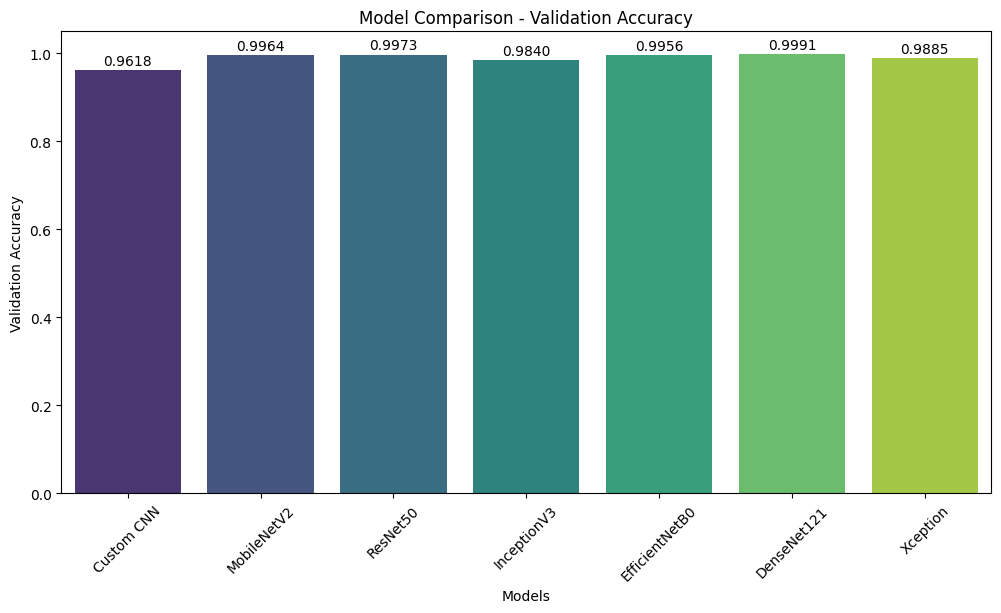

In [29]:
summarize_and_compare_models(results)